# Vanilla GAN Implementation with MNIST Dataset

This notebook implements a basic Generative Adversarial Network (GAN) using the MNIST dataset.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# Load and preprocess MNIST dataset
(x_train, _), (_, _) = keras.datasets.mnist.load_data()

# Normalize to [-1, 1] range
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = x_train.reshape(x_train.shape[0], 784)  # Flatten images

print(f"Training data shape: {x_train.shape}")
print(f"Data range: [{x_train.min():.2f}, {x_train.max():.2f}]")

Training data shape: (60000, 784)
Data range: [-1.00, 1.00]


In [3]:
# Generator Model
def build_generator(latent_dim=100):
    model = keras.Sequential([
        layers.Dense(256, input_dim=latent_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        
        layers.Dense(1024),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        
        layers.Dense(784, activation='tanh')
    ], name='generator')
    
    return model

# Discriminator Model
def build_discriminator():
    model = keras.Sequential([
        layers.Dense(1024, input_dim=784),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Dense(1, activation='sigmoid')
    ], name='discriminator')
    
    return model

In [4]:
# Build and compile models
latent_dim = 100

# Build generator and discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator()

# Compile discriminator
discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build and compile GAN
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)
gan = keras.Model(gan_input, gan_output, name='vanilla_gan')

gan.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)

print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()

Generator Summary:
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                     

In [5]:
# Training functions
def generate_and_save_images(generator, epoch, test_input, save_dir='vanilla_gan_images'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    predictions = generator(test_input, training=False)
    predictions = predictions.numpy().reshape(-1, 28, 28)
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i], cmap='gray')
        plt.axis('off')
    
    plt.suptitle(f'Generated Images - Epoch {epoch}')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/vanilla_gan_epoch_{epoch}.png')
    plt.show()

def train_gan(generator, discriminator, gan, dataset, epochs=50, batch_size=128):
    # Create directory for saving models
    if not os.path.exists('vanilla_gan_models'):
        os.makedirs('vanilla_gan_models')
    
    # Fixed noise for consistent image generation
    fixed_noise = tf.random.normal([16, latent_dim])
    
    # Training history
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        epoch_d_loss = []
        epoch_g_loss = []
        
        # Create batches
        num_batches = len(dataset) // batch_size
        
        for batch_idx in range(num_batches):
            # Get real images
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            real_images = dataset[start_idx:end_idx]
            
            # Generate fake images
            noise = tf.random.normal([batch_size, latent_dim])
            fake_images = generator(noise, training=True)
            
            # Train discriminator
            discriminator.trainable = True
            
            # Real images
            d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
            # Fake images
            d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Train generator
            discriminator.trainable = False
            noise = tf.random.normal([batch_size, latent_dim])
            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
            
            epoch_d_loss.append(d_loss[0])
            epoch_g_loss.append(g_loss)
        
        # Record losses
        d_losses.append(np.mean(epoch_d_loss))
        g_losses.append(np.mean(epoch_g_loss))
        
        # Print progress and generate images
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Discriminator Loss: {d_losses[-1]:.4f}")
            print(f"Generator Loss: {g_losses[-1]:.4f}")
            print("-" * 50)
            
            generate_and_save_images(generator, epoch+1, fixed_noise)
            
            # Save models
            generator.save(f'vanilla_gan_models/generator_epoch_{epoch+1}.h5')
            discriminator.save(f'vanilla_gan_models/discriminator_epoch_{epoch+1}.h5')
    
    return d_losses, g_losses

Starting Vanilla GAN training...
Epoch 10/50
Discriminator Loss: 0.6152
Generator Loss: 1.0535
--------------------------------------------------


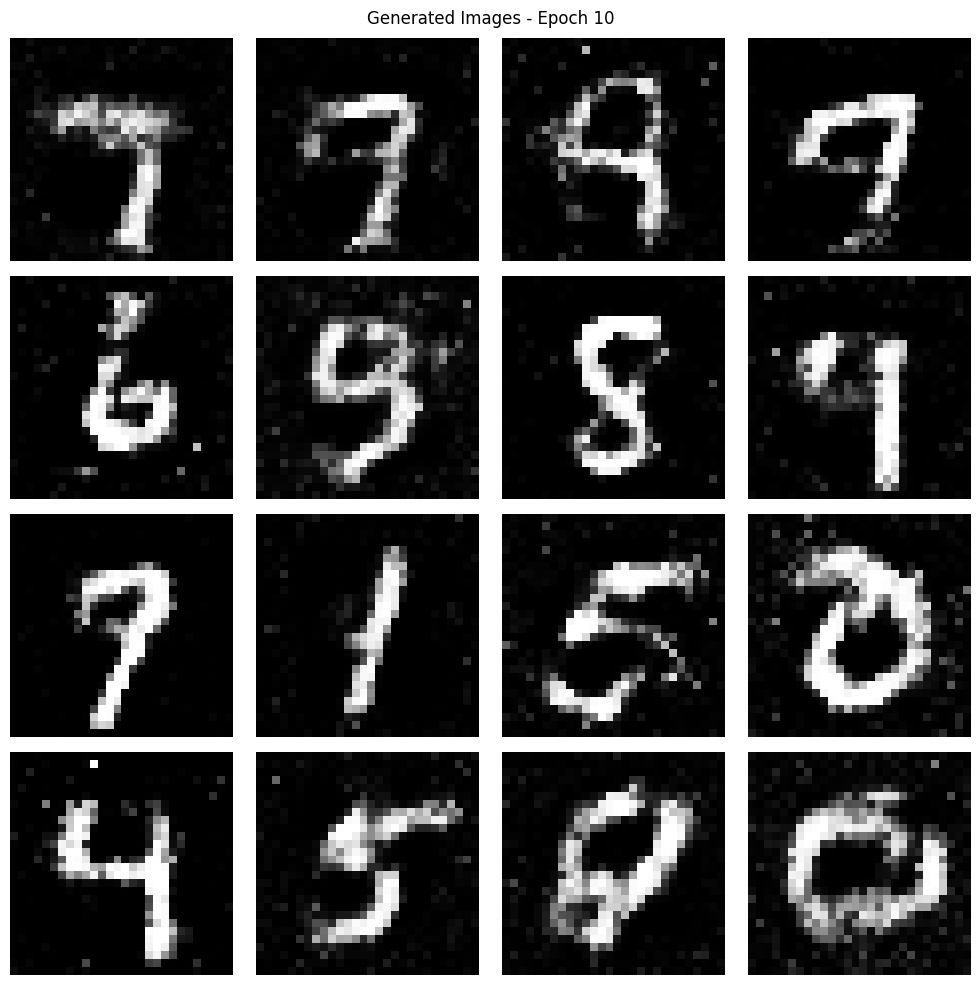

c:\Users\Aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 20/50
Discriminator Loss: 0.6662
Generator Loss: 0.8463
--------------------------------------------------


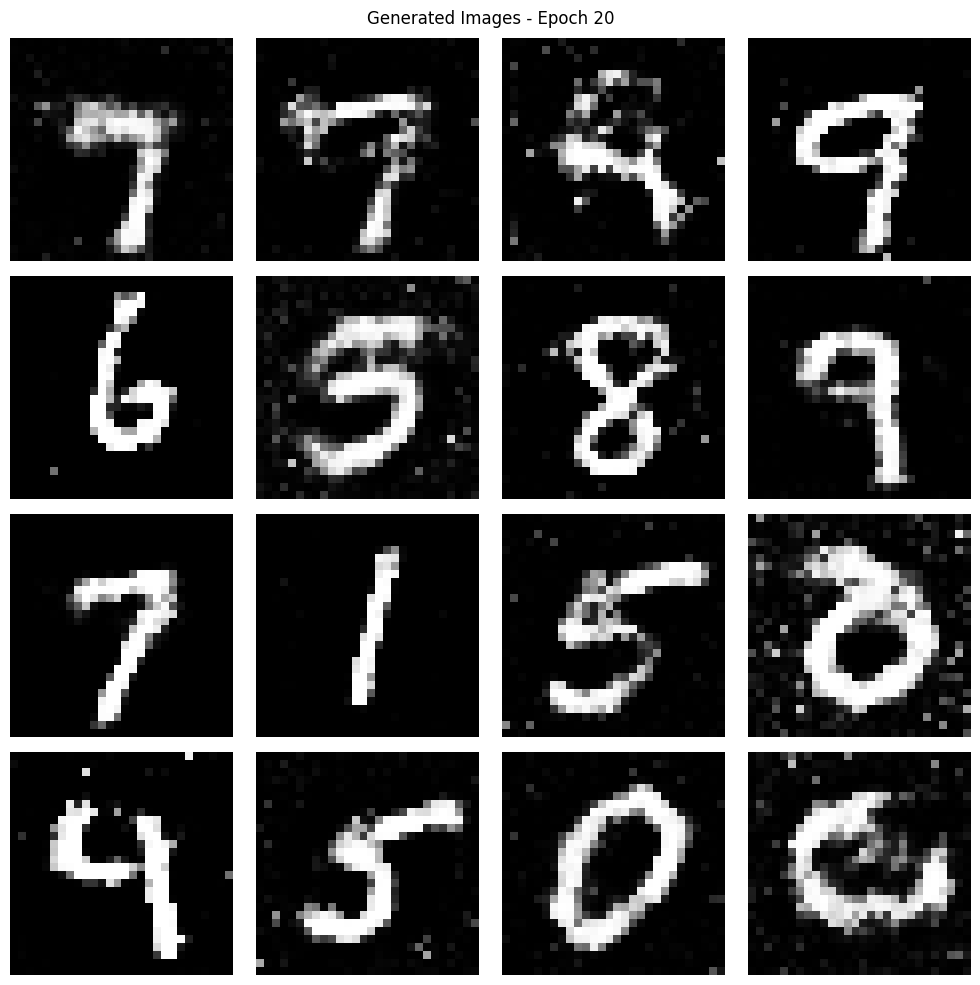

Epoch 30/50
Discriminator Loss: 0.6712
Generator Loss: 0.8120
--------------------------------------------------


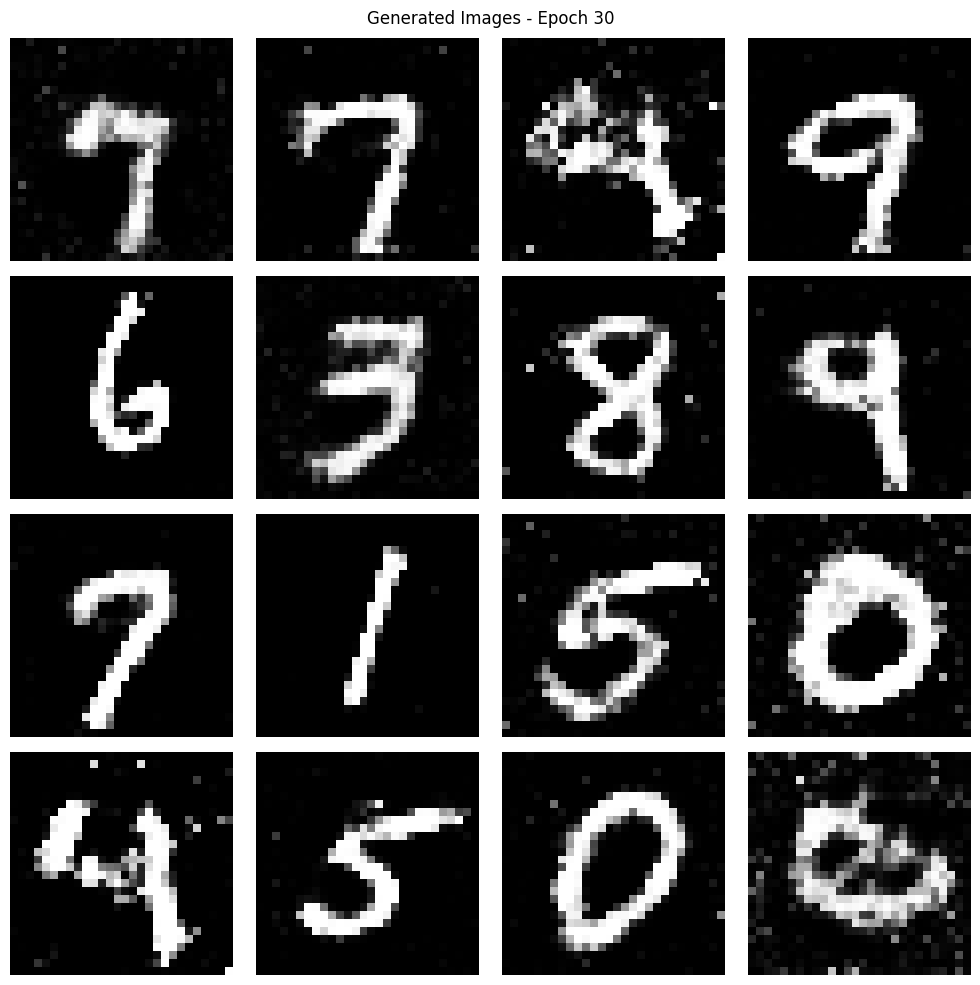

Epoch 40/50
Discriminator Loss: 0.6733
Generator Loss: 0.7996
--------------------------------------------------


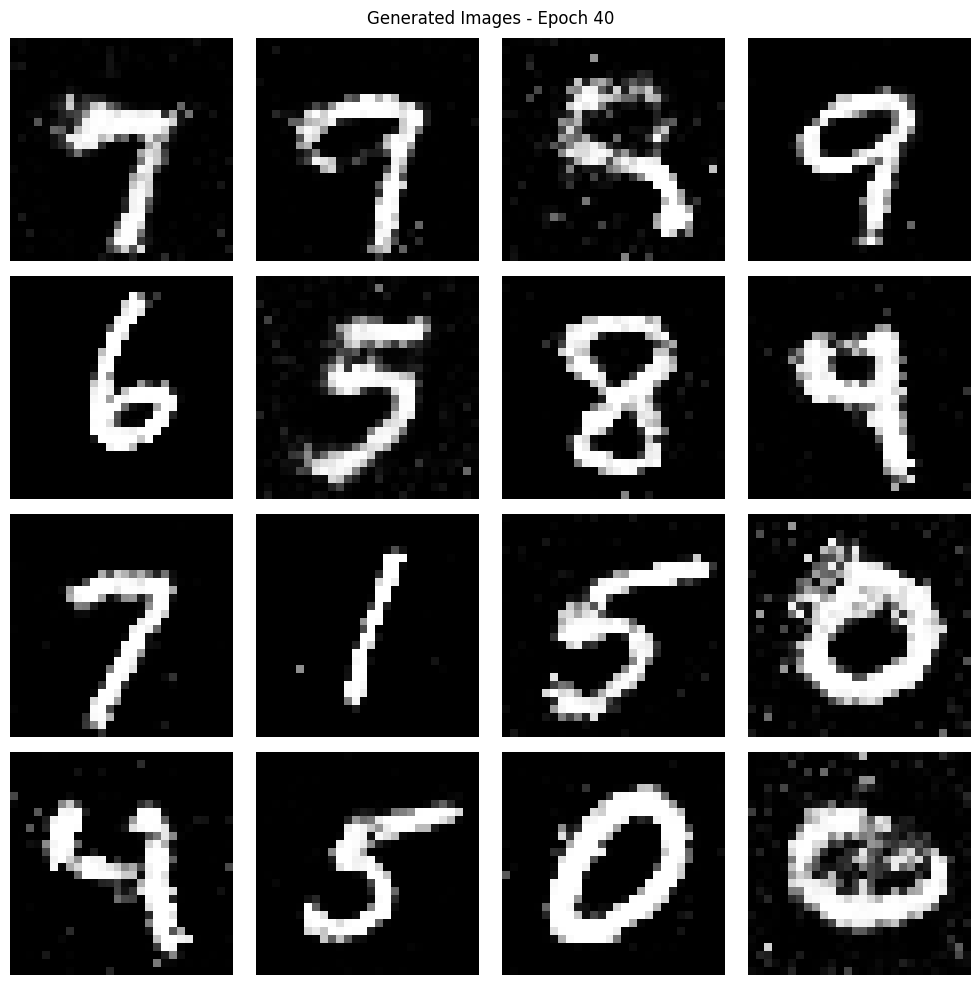

Epoch 50/50
Discriminator Loss: 0.6727
Generator Loss: 0.7911
--------------------------------------------------


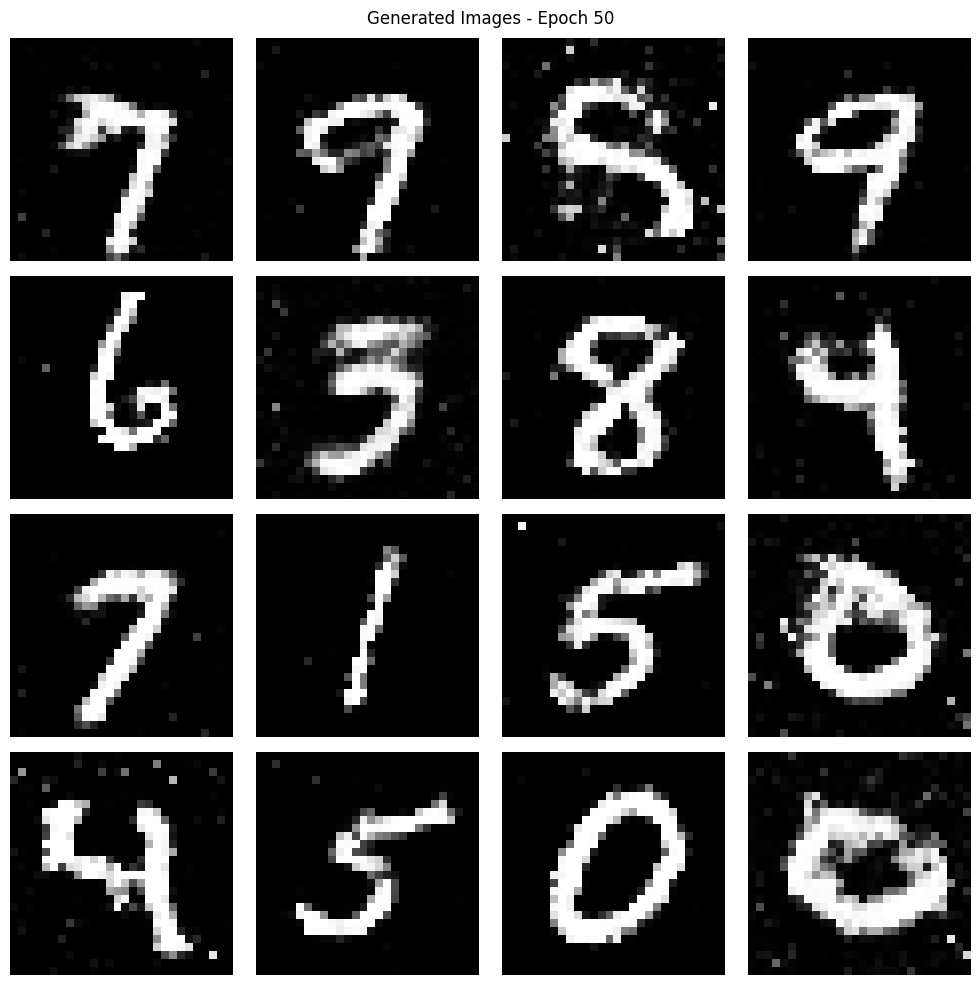

Training completed!


In [6]:
# Train the GAN
print("Starting Vanilla GAN training...")
d_losses, g_losses = train_gan(generator, discriminator, gan, x_train, epochs=50, batch_size=128)

print("Training completed!")

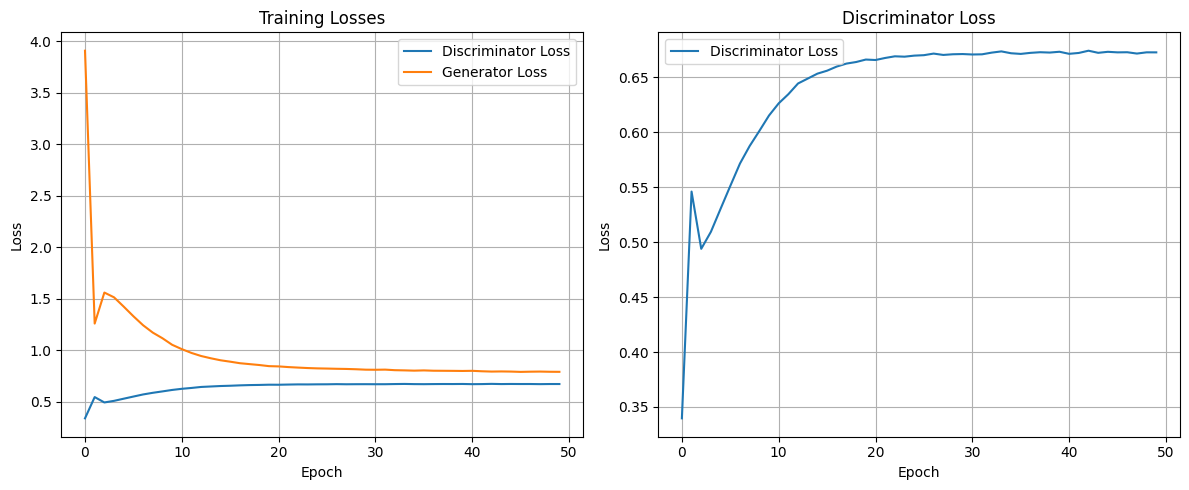

In [7]:
# Plot training losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('vanilla_gan_training_losses.png')
plt.show()

Generating final images...


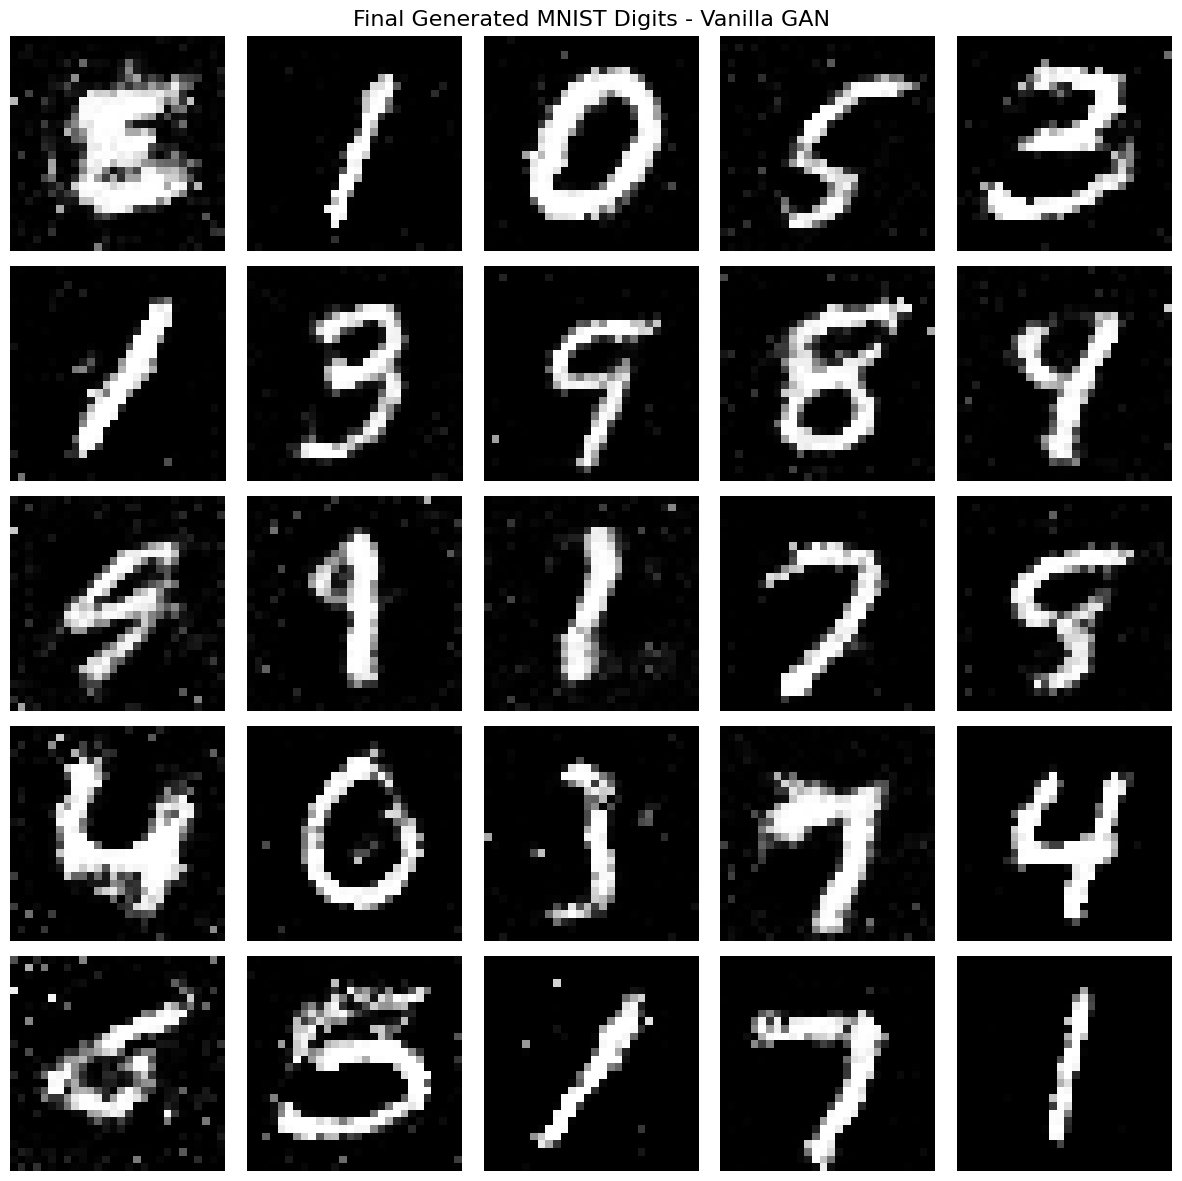

In [8]:
# Generate final images
print("Generating final images...")
test_noise = tf.random.normal([25, latent_dim])
generated_images = generator(test_noise, training=False)
generated_images = generated_images.numpy().reshape(-1, 28, 28)

plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')

plt.suptitle('Final Generated MNIST Digits - Vanilla GAN', fontsize=16)
plt.tight_layout()
plt.savefig('vanilla_gan_final_results.png')
plt.show()

In [9]:
# Save final models
generator.save('vanilla_gan_models/final_generator.h5')
discriminator.save('vanilla_gan_models/final_discriminator.h5')
gan.save('vanilla_gan_models/final_gan.h5')

print("Models saved successfully!")
print("\nFiles created:")
print("- Generator models in 'vanilla_gan_models/' directory")
print("- Generated images in 'vanilla_gan_images/' directory")
print("- Training loss plots saved as 'vanilla_gan_training_losses.png'")
print("- Final results saved as 'vanilla_gan_final_results.png'")

Models saved successfully!

Files created:
- Generator models in 'vanilla_gan_models/' directory
- Generated images in 'vanilla_gan_images/' directory
- Training loss plots saved as 'vanilla_gan_training_losses.png'
- Final results saved as 'vanilla_gan_final_results.png'
